In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

输出两张图片，左边为有雾图像，右边为去雾图像。

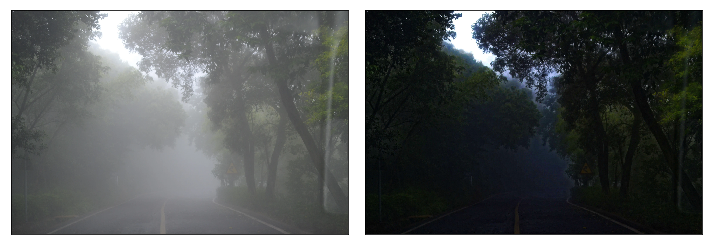

In [12]:
def minimum_Filter(img, r=7):  
    return cv2.erode(img,np.ones((2*r+1,2*r+1)))

def guided_filter(img, a, r, eps):   
    height, width = img.shape[:2]  
    new_img = cv2.boxFilter(img, -1, (r,r))  
    new_a = cv2.boxFilter(a, -1, (r,r))  
    new_ia = cv2.boxFilter(img*a, -1, (r,r))  
    val_ia = new_ia-new_img*new_a  
   
    new_img2 = cv2.boxFilter(img*img, -1, (r,r))  
    var_img = new_img2-new_img*new_img  
   
    m = val_ia/(var_img+eps)  
    n = new_a-m*new_img  
   
    new_m = cv2.boxFilter(m, -1, (r,r))  
    new_n = cv2.boxFilter(n, -1, (r,r))  
    return new_m*img+new_n  
   
def getJdark(img, r, eps, w, maxJ):
    J = np.min(img,2) #暗通道图像  
    J = guided_filter(J, minimum_Filter(J,7), r, eps)
    bins = 2000  
    ht = np.histogram(J, bins)                                
    d = np.cumsum(ht[0])/float(J.size)  
    for i in range(bins-1, 0, -1):  
        if d[i]<=0.999:  
            break  
    A  = np.mean(img,2)[J>=ht[1][i]].max() #大气光照A 
           
    J = np.minimum(J*w, maxJ)
       
    return J,A  
   
def defog(img, r=81, eps=0.001, w=0.95, maxJ=0.80):  
    image = np.zeros(img.shape)  
    J,A = getJdark(img, r, eps, w, maxJ)  
    for k in range(3):  
        image[:,:,k] = (img[:,:,k]-J)/(1-J/A)
    image =  np.clip(image, 0, 1)  
    return image  
   
if __name__ == '__main__':  
    img = Image.open('wu.jpg')
    m = defog(cv2.imread('wu.jpg')/255.0)*255  
    cv2.imwrite('test.jpg', m)
    im1 = Image.open('test.jpg') 
    plt.figure(figsize=(10, 7))
    plt.subplot(121), plt.imshow(img), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(im1), plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()